### Loading the modules

In [15]:
import pandas as pd
import os
!pip install tensorflow  # Ensure TensorFlow is installed
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import numpy as np


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the dataset

In [17]:
df = pd.read_csv('/content/drive/MyDrive/classes_NUS/Project_Module_2/archive/glaucoma.csv', sep=',')
df.head()

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


In [18]:
df.describe()

,ExpCDR,Glaucoma
count,650.000000,650.000000
mean,0.576308,0.258462
std,0.116395,0.438126
min,0.161000,0.000000
25%,0.496675,0.000000
50%,0.567650,0.000000
75%,0.648475,1.000000
max,0.962900,1.000000


### Function - filename_to_label_mapping_dict() - Dictionary with filename , label mapping

In [19]:
filename_to_label_mapping_dict = dict(zip(df['Filename'],df['Glaucoma']))

### Function - no_of_out_class() - to get the number of output class

In [20]:
def no_of_out_class(labels):
  #class_label_count = label_all.shape[1]
  unique_labels, label_counts = np.unique(labels, return_counts=True)
  class_label_count = len(unique_labels)
  print(f"No of output classes : {class_label_count}")
  return class_label_count

### Function : load_images_from_folder_model_specific() - load images from remote file location




In [25]:
#load images and match the corresponding images
def load_images_from_folder_model_specific(filename, img_dir, filename_to_label_mapping_dict):
  #filename
  #img_dir
  #label_dict

  img_path = os.path.join(img_dir, filename)
  img = load_img(img_path, color_mode='rgb',target_size=(224, 224))
  img_arr = img_to_array(img) / 255.0 #divide by 255 is needed for imshow() api to display the image properly,
  #imshow() with RGB images, the input must be either float in range[0,1] or integer in range[0, 255]
  #earlier it was float with range beyond 1, so normalized to make the range from [0,1].
  label = filename_to_label_mapping_dict[filename]
  return img_arr, label


In [26]:
#plot the img and labels
def show_img_arr_label(img_arr, label):
  plt.imshow(img_arr)
  plt.title(f'Label : {label}')
  plt.show()

### MAIN EDA ANALYSIS :

In [27]:
img_dir = '/content/drive/MyDrive/classes_NUS/Project_Module_2/archive/ORIGA/ORIGA/Images/'

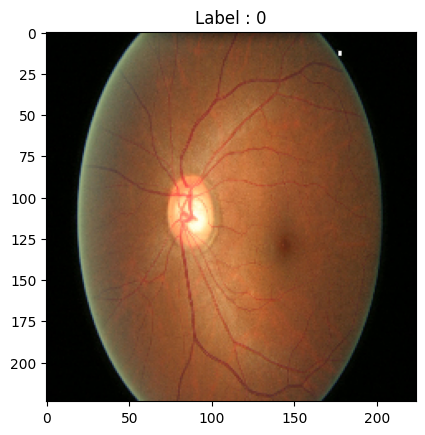

In [28]:
img_arr, label = load_images_from_folder_model_specific("005.jpg", img_dir, filename_to_label_mapping_dict)
show_img_arr_label(img_arr, label)

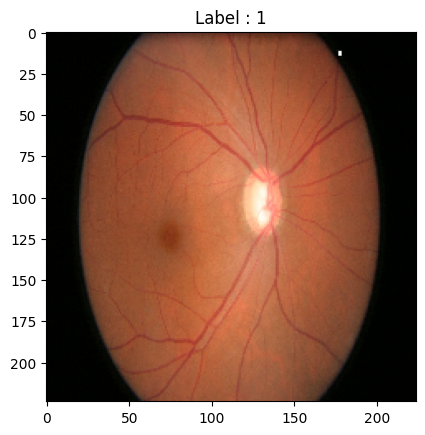

In [31]:
img_arr, label = load_images_from_folder_model_specific("050.jpg", img_dir, filename_to_label_mapping_dict)
show_img_arr_label(img_arr, label)

In [32]:
print(f"Shape of the image : {img_arr.shape}")

Shape of the image : (224, 224, 3)


#### DATA IMBALANCE CHECK
- Pre-processing of glaucoma.csv to check if the data is imabalanced, and using appropriate data balancing technique

No of Glaucoma : 168
No of Non-Glaucoma : 482


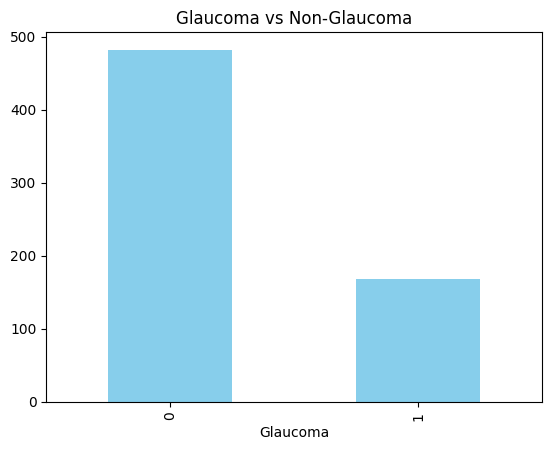

In [33]:
# check if the data is imbalanced
class_counts = df['Glaucoma'].value_counts()
print(f"No of Glaucoma : {class_counts[1]}")
print(f"No of Non-Glaucoma : {class_counts[0]}")
class_counts.plot(kind='bar', color='skyblue')
plt.title('Glaucoma vs Non-Glaucoma')
plt.show()

In [34]:
ratio_label_0 = class_counts[0] / len(df)
ratio_label_1 = class_counts[1] / len(df)
print(f"Ratio of Glaucoma : {ratio_label_1}")
print(f"Ratio of Non-Glaucoma : {ratio_label_0}")
if ratio_label_0 > 0.7 or ratio_label_1 > 0.7:
  print("Data is imbalanced, so proceeding with data balancing method - Class weights")
  # since data is imbalanced, we can do undersampling, or oversampling or class weights methods for balancing the data set
  # the no of samples in the dataset is only 650, so insteas of removing , will use class weights or oversampling method
  # class_weights can be used during model training, these weights will help to mitigate the negative impact of the class imabalance
  class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(df['Glaucoma']), y = df['Glaucoma'])
  class_weights = dict(enumerate(class_weights))
  print(f"Class Weights : {class_weights}")
else:
  print("Data is balanced")

Ratio of Glaucoma : 0.25846153846153846
Ratio of Non-Glaucoma : 0.7415384615384616
Data is imbalanced, so proceeding with data balancing method - Class weights
Class Weights : {0: 0.6742738589211619, 1: 1.9345238095238095}


#### Image data inspection
- To check for **uniformity** in dimensions
    - All the images have same dimensions as per the results from the check_image_dimensions() function.
- To check ** aspect ratios ** - all the images are (224,224,3)
    - print(f"Shape of the image array : {img_arr.shape}")
    - Shape of the image : (224, 224, 3)

In [35]:
# this function is slow, takes about 4mints to process through all the 650 images,
# cannot be used for large dataset.
def check_image_dimensions(img_dir, filename_to_label_mapping_dict):
       """
       Checks dimensions of all images and prints if they are uniform.
       """
       all_same_dim = True
       first_shape = None

       for filename in filename_to_label_mapping_dict.keys():
           img, label = load_images_from_folder_model_specific(filename, img_dir,filename_to_label_mapping_dict) # Load image without resizing

           if first_shape is None:
               first_shape = img.size
           elif img.size != first_shape:
               all_same_dim = False
               break

       if all_same_dim:
           print("All images have the same dimensions.")
       else:
           print("Images have different dimensions.")


In [36]:
check_image_dimensions(img_dir, filename_to_label_mapping_dict)

All images have the same dimensions.


#### Color Analysis
- Channel mean and standard deviation - to calculate the mean and standard deviation of each color (RGB) to standardize or normalise.
- Color Histogram - To observe the pixel intensity distributions across classes, to check for color biases

#### Noise - Image quality and resolution analysis
- Blur detection - Variance of the Laplacian
- Noise Detection - Statistical method

#### Image Orientation
- Misaligned images can affect model learning, hence need to check this.